Link to Dataset: [here](https://drive.google.com/file/d/1IoSvP6NUhIASIVhujHtVIIU-WVcJKMt6/view?usp=sharing)

In [ ]:
Link to Dataset: [here](https://drive.google.com/file/d/1IoSvP6NUhIASIVhujHtVIIU-WVcJKMt6/view?usp=sharing)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from shapely.geometry import Point

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score, f1_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from folium.plugins import MarkerCluster


file_path = "/content/Gempa_Dataset.csv"
df = pd.read_csv(file_path)


print("Shape of the dataset:", df.shape)
print("Columns in the dataset:", df.columns)
df.head()


Shape of the dataset: (116999, 11)
Columns in the dataset: Index([' eventID', 'datetime', 'latitude', 'longitude', 'magnitude',
       'mag_type', 'depth', 'phasecount', 'azimuth_gap', 'location', 'agency'],
      dtype='object')


eventID                          datetime  latitude   longitude  \
0  bmg2008vkye  2008-11-01 00:31:25.143741+00:00 -0.604440   98.895531   
1  bmg2008vlag  2008-11-01 01:34:29.660856+00:00 -6.611860  129.387220   
2  bmg2008vlaj  2008-11-01 01:38:14.802129+00:00 -3.650586  127.990680   
3  bmg2008vlbt  2008-11-01 02:20:05.909515+00:00 -4.198925  128.097000   
4  bmg2008vlcd  2008-11-01 02:32:18.756155+00:00 -4.091891  128.200470   

   magnitude mag_type  depth  phasecount  azimuth_gap  \
0   2.989742      MLv     20         6.0    146.70738   
1   5.507549       mb     30        62.0     45.46764   
2   3.539674      MLv      5         4.0    331.97404   
3   2.424314      MLv      5         5.0    326.37993   
4   2.410045      MLv     10         5.0    314.65474   

                      location agency  
0  Southern Sumatra, Indonesia    NaN  
1                    Banda Sea    NaN  
2             Seram, Indonesia    NaN  
3                    Banda Sea    NaN  
4                    Banda Sea    NaN

In [2]:
# Impute missing values in 'magnitude' and 'depth' with median
df['magnitude'] = df['magnitude'].fillna(df['magnitude'].median())
df['depth'] = df['depth'].fillna(df['depth'].median())

# If location is critical, consider replacing missing values with 'Unknown' or imputing based on nearby rows
df['location'] = df['location'].fillna('Unknown')

# Fill missing values for other columns as before
df['agency'] = df['agency'].fillna('BMKG')
df['phasecount'] = df['phasecount'].fillna(df['phasecount'].median())
df['azimuth_gap'] = df['azimuth_gap'].fillna(df['azimuth_gap'].median())


In [3]:
# Create a new binary target column 'tsunami'
df['tsunami'] = np.where((df['magnitude'] >= 6.0) & (df['depth'] <= 30), 1, 0)


In [4]:

def assign_risk(magnitude, depth):
    if magnitude >= 7.0 and depth <= 20:
        return "High"
    elif magnitude >= 6.0 and depth <= 30:
        return "Medium"
    else:
        return "Low"

# Apply the function to create a new column for risk levels
df['risk_level'] = df.apply(lambda x: assign_risk(x['magnitude'], x['depth']), axis=1)

# Sort data based on risk level (High > Medium > Low), high magnitude (descending), and shallow depth (ascending)
def risk_level_key(level):
    return {"High": 0, "Medium": 1, "Low": 2}[level]

df = df.sort_values(by=['risk_level', 'magnitude', 'depth'],
                    key=lambda col: col.map(risk_level_key) if col.name == 'risk_level' else col,
                    ascending=[True, False, True])

# Assign rank based on the sorted order
df['rank'] = df.reset_index(drop=True).index + 1

# Save the updated DataFrame to a new CSV file
output_file = "/content/Ranked_Earthquake_Data.csv"  # Replace with your output file path
df.to_csv(output_file, index=False)

# Display the top-ranked earthquakes
print("Top-ranked earthquakes based on risk level and danger level:")
print(df[['magnitude', 'depth', 'risk_level', 'rank']].head())

# Display the distribution of risk levels
print("\nDistribution of risk levels:")
print(df['risk_level'].value_counts())

# Optional: Show the sorted DataFrame structure for verification
print("\nSample of the ranked dataset:")
print(df.head(10))

# Count the number of earthquakes per location
location_counts = df['location'].value_counts()

# Determine risk zones based on the frequency distribution of locations in the dataset
# For example, High Risk: Most frequent locations, Medium Risk: Medium frequency, Low Risk: Low frequency
def assign_risk_zone_from_dataset(location):
    if location_counts[location] > location_counts.quantile(0.66):
        return 'High Risk'
    elif location_counts[location] > location_counts.quantile(0.33):
        return 'Medium Risk'
    else:
        return 'Low Risk'

df['risk_zone'] = df['location'].apply(assign_risk_zone_from_dataset)

risk_zone_distribution = df['risk_zone'].value_counts()
risk_zone_distribution


Top-ranked earthquakes based on risk level and danger level:
       magnitude  depth risk_level  rank
333     7.923472     17       High     1
72964   7.894698     10       High     2
62409   7.454625      9       High     3
87836   7.429541     10       High     4
6967    7.216571     10       High     5

Distribution of risk levels:
risk_level
Low       116725
Medium       259
High          15
Name: count, dtype: int64

Sample of the ranked dataset:
           eventID                          datetime  latitude   longitude  \
333    bmg2009afdz  2009-01-03 19:43:54.962255+00:00 -0.539336  132.892470   
72964  bmg2020nfkm  2020-07-06 22:56:23.721844+00:00 -6.650591  110.185448   
62409  bmg2019mgdc  2019-06-24 02:48:07.049203+00:00 -2.616023  138.612396   
87836  bmg2021ykge  2021-12-14 03:20:23.200204+00:00 -7.588856  122.247368   
6967   bmg2010lrix  2010-06-16 03:16:28.385704+00:00 -2.154486  136.570940   
66701  bmg2019wikz  2019-11-14 16:25:25.806571+00:00 -3.765099  128.610916  

risk_zone
High Risk      100701
Medium Risk     15340
Low Risk          958
Name: count, dtype: int64

In [5]:
df.head()

eventID                          datetime  latitude   longitude  \
333    bmg2009afdz  2009-01-03 19:43:54.962255+00:00 -0.539336  132.892470   
72964  bmg2020nfkm  2020-07-06 22:56:23.721844+00:00 -6.650591  110.185448   
62409  bmg2019mgdc  2019-06-24 02:48:07.049203+00:00 -2.616023  138.612396   
87836  bmg2021ykge  2021-12-14 03:20:23.200204+00:00 -7.588856  122.247368   
6967   bmg2010lrix  2010-06-16 03:16:28.385704+00:00 -2.154486  136.570940   

       magnitude mag_type  depth  phasecount  azimuth_gap  \
333     7.923472   Mw(mB)     17       104.0    60.960369   
72964   7.894698   Mw(mB)     10        21.0   142.439430   
62409   7.454625       Mw      9         6.0   340.179359   
87836   7.429541   Mw(mB)     10       502.0    10.727951   
6967    7.216571   Mw(mB)     10       180.0    55.084959   

                           location agency  tsunami risk_level  rank  \
333    Irian Jaya Region, Indonesia   BMKG        1       High     1   
72964               Java, Indonesia   BMKG        1       High     2   
62409         Irian Jaya, Indonesia   BMKG        1       High     3   
87836                    Flores Sea   BMKG        1       High     4   
6967   Irian Jaya Region, Indonesia    BMG        1       High     5   

         risk_zone  
333      High Risk  
72964    High Risk  
62409  Medium Risk  
87836    High Risk  
6967     High Risk

In [6]:
df.head()
df['tsunami'].value_counts()

tsunami
0    116725
1       274
Name: count, dtype: int64

Using Rankend Data

In [7]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    balanced_accuracy_score, f1_score, precision_recall_curve
)
import numpy as np
import pandas as pd


file_path = "/content/Ranked_Earthquake_Data.csv"
df = pd.read_csv(file_path)


In [8]:
df.head()

eventID                          datetime  latitude   longitude  \
0  bmg2009afdz  2009-01-03 19:43:54.962255+00:00 -0.539336  132.892470   
1  bmg2020nfkm  2020-07-06 22:56:23.721844+00:00 -6.650591  110.185448   
2  bmg2019mgdc  2019-06-24 02:48:07.049203+00:00 -2.616023  138.612396   
3  bmg2021ykge  2021-12-14 03:20:23.200204+00:00 -7.588856  122.247368   
4  bmg2010lrix  2010-06-16 03:16:28.385704+00:00 -2.154486  136.570940   

   magnitude mag_type  depth  phasecount  azimuth_gap  \
0   7.923472   Mw(mB)     17       104.0    60.960369   
1   7.894698   Mw(mB)     10        21.0   142.439430   
2   7.454625       Mw      9         6.0   340.179359   
3   7.429541   Mw(mB)     10       502.0    10.727951   
4   7.216571   Mw(mB)     10       180.0    55.084959   

                       location agency  tsunami risk_level  rank  
0  Irian Jaya Region, Indonesia   BMKG        1       High     1  
1               Java, Indonesia   BMKG        1       High     2  
2         Irian Jaya, Indonesia   BMKG        1       High     3  
3                    Flores Sea   BMKG        1       High     4  
4  Irian Jaya Region, Indonesia    BMG        1       High     5

In [13]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    balanced_accuracy_score, f1_score, make_scorer
)
import numpy as np
import pandas as pd

# Define features and target, excluding 'magnitude' and 'depth'
features = ['depth','azimuth_gap', 'phasecount', 'latitude', 'longitude']
X = df[features]
y = df['tsunami']

# Step 1: Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nDistribution of training data before balancing:")
print(y_train.value_counts())

# Step 2: Downsampling
rus = RandomUnderSampler(sampling_strategy={0: 219, 1: 219}, random_state=42)
X_train_down, y_train_down = rus.fit_resample(X_train, y_train)
print("\nDistribution of training data after downsampling:")
print(pd.Series(y_train_down).value_counts())

# Step 3: SMOTE for increasing minority class
smote = SMOTE(sampling_strategy={0: 319, 1: 319}, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_down, y_train_down)
print("\nDistribution of training data after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

print(f"Number of test samples: {len(X_test)}")

# Step 4: Adjust test data distribution to be balanced
# Separate tsunami and non-tsunami data
tsunami_data = X_test[y_test == 1]
non_tsunami_data = X_test[y_test == 0]

# Sample non-tsunami data to match the size of tsunami data
non_tsunami_sampled = non_tsunami_data.sample(n=len(tsunami_data) * 2, random_state=42, replace=False)

# Combine test data back
X_test_balanced = pd.concat([tsunami_data, non_tsunami_sampled])
y_test_balanced = y_test.loc[X_test_balanced.index]

# Ensure the new test data distribution
print("\nDistribution of test data after adjustment:")
print(y_test_balanced.value_counts())

# Step 5: Scale Data
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_balanced_scaled = scaler.transform(X_test_balanced)

# Step 6: Model Dictionary with added regularization
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=5000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Step 7: Cross-Validation Function
def cross_validate_model(model, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    results = cross_val_score(model, X, y, scoring='roc_auc', cv=skf)
    print(f"\nCross-Validation ROC-AUC (mean): {results.mean():.4f} (std: {results.std():.4f})")

# Step 8: Model Evaluation (Focus on Tsunami)
def evaluate_model(model, X_test, y_test):
    model.fit(X_train_smote_scaled, y_train_smote)  # Train the model with training data
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    # Adjust threshold to focus on tsunami
    threshold = 0.3
    y_pred = (y_proba >= threshold).astype(int)

    print("\nConfusion Matrix :")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["No Tsunami", "Tsunami"]))

    # Additional Metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    precision = classification_report(y_test, y_pred, output_dict=True)['Tsunami']['precision']
    recall = classification_report(y_test, y_pred, output_dict=True)['Tsunami']['recall']
    f1_minor = f1_score(y_test, y_pred, pos_label=1)

    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"Precision (Tsunami): {precision:.4f}")
    print(f"Recall (Tsunami): {recall:.4f}")
    print(f"F1-Score (Tsunami): {f1_minor:.4f}")

# Step 9: Feature Importance (Visualization removed)
def get_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        print("\nFeature Importances:")
        print(feature_importance)
    elif hasattr(model, 'coef_'):
        coefficients = model.coef_[0]
        coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
        coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
        print("\nFeature Coefficients:")
        print(coef_df)

# Step 10: Evaluate and Visualize All Models (with Cross-Validation)
for model_name, model in models.items():
    print(f"\n=== Evaluating {model_name} ===")
    try:
        cross_validate_model(model, X_train_smote_scaled, y_train_smote)
        evaluate_model(model, X_test_balanced_scaled, y_test_balanced)
    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        continue

    # Display Feature Importance if available
    get_feature_importance(model, features)

# Step 11: Summarize Actual vs Predicted (Focus on Tsunami)
def summarize_predictions(model, model_name, X_test, y_test):
    model.fit(X_train_smote_scaled, y_train_smote)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    # Adjust threshold to focus on tsunami
    threshold = 0.3
    y_pred = (y_proba >= threshold).astype(int)

    tsunami_actual = y_test.sum()  # Number of actual tsunami cases
    tsunami_predicted = y_pred.sum()  # Number of predicted tsunami cases

    print(f"\n=== Prediction Summary {model_name} ===")
    print(f"Tsunami Actual: {tsunami_actual}")
    print(f"Tsunami Predicted: {tsunami_predicted}")

# Evaluate all models and display summary
for model_name, model in models.items():
    print(f"\n=== Prediction Summary {model_name} ===")
    try:
        summarize_predictions(model, model_name, X_test_balanced_scaled, y_test_balanced)
    except Exception as e:
        print(f"Error summarizing predictions for {model_name}: {e}")
        continue



Distribution of training data before balancing:
tsunami
0    93380
1      219
Name: count, dtype: int64

Distribution of training data after downsampling:
tsunami
0    219
1    219
Name: count, dtype: int64

Distribution of training data after SMOTE:
tsunami
0    319
1    319
Name: count, dtype: int64
Number of test samples: 23400

Distribution of test data after adjustment:
tsunami
0    110
1     55
Name: count, dtype: int64

=== Evaluating Logistic Regression ===

Cross-Validation ROC-AUC (mean): 0.8487 (std: 0.0219)

Confusion Matrix :
[[55 55]
 [ 1 54]]

Classification Report:
              precision    recall  f1-score   support

  No Tsunami       0.98      0.50      0.66       110
     Tsunami       0.50      0.98      0.66        55

    accuracy                           0.66       165
   macro avg       0.74      0.74      0.66       165
weighted avg       0.82      0.66      0.66       165

Error evaluating Logistic Regression: 'Tsunami'

=== Evaluating Decision Tree ===

C

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 57.6 MB/s eta 0:00:00

=== Visualizing Logistic Regression (All Features) ===


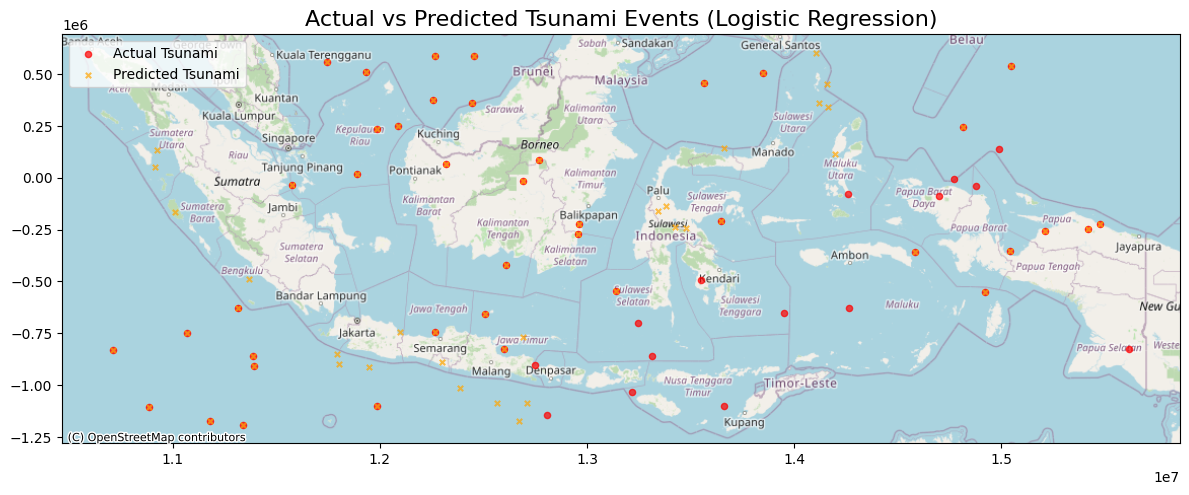

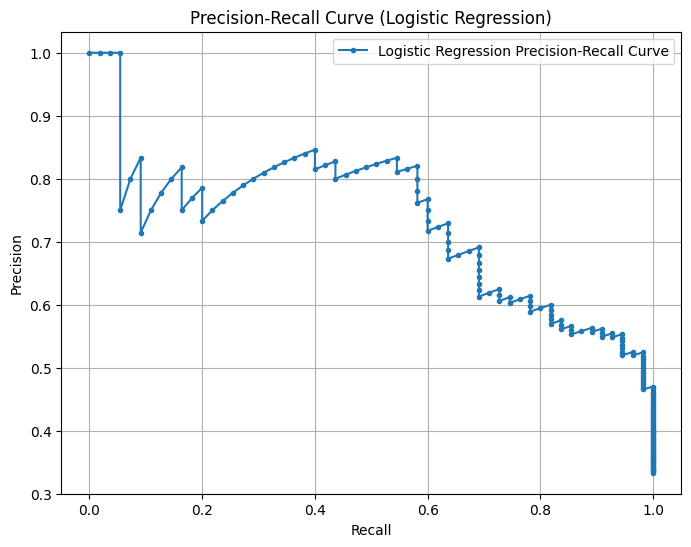


=== Visualizing Decision Tree (All Features) ===


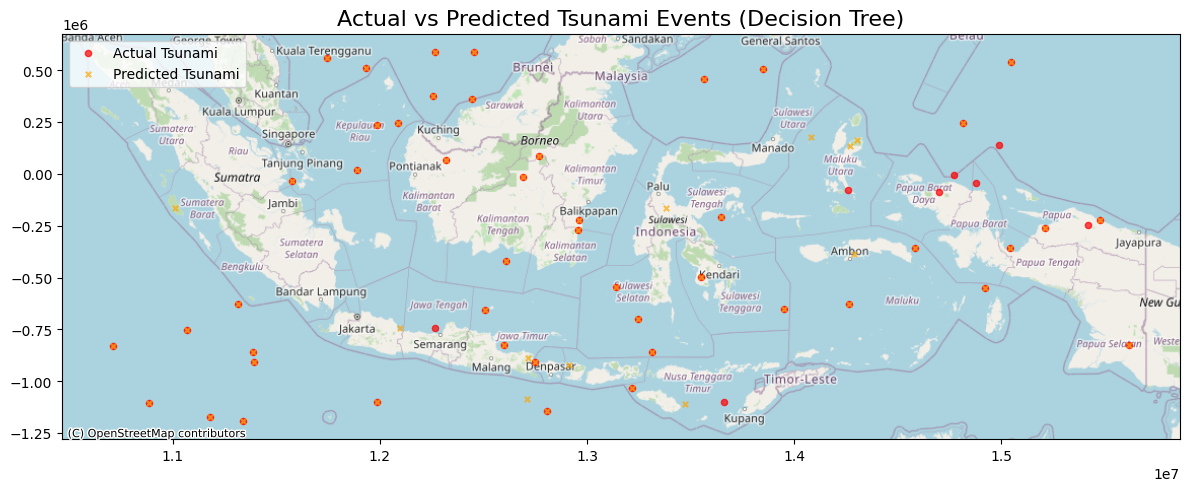

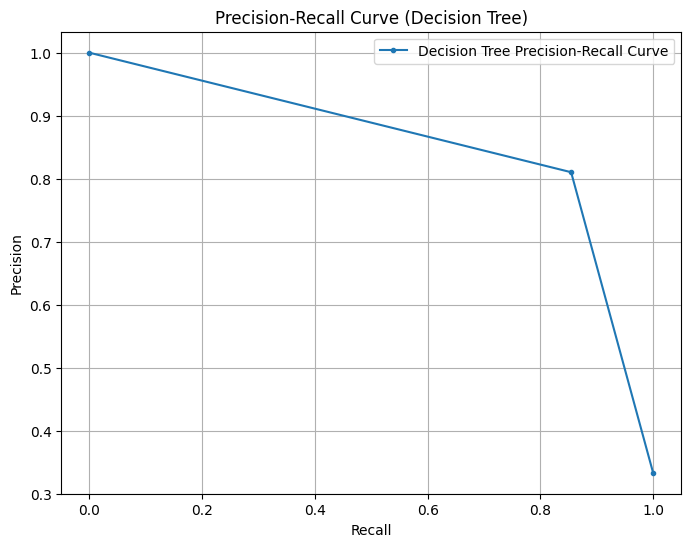


=== Visualizing Random Forest (All Features) ===


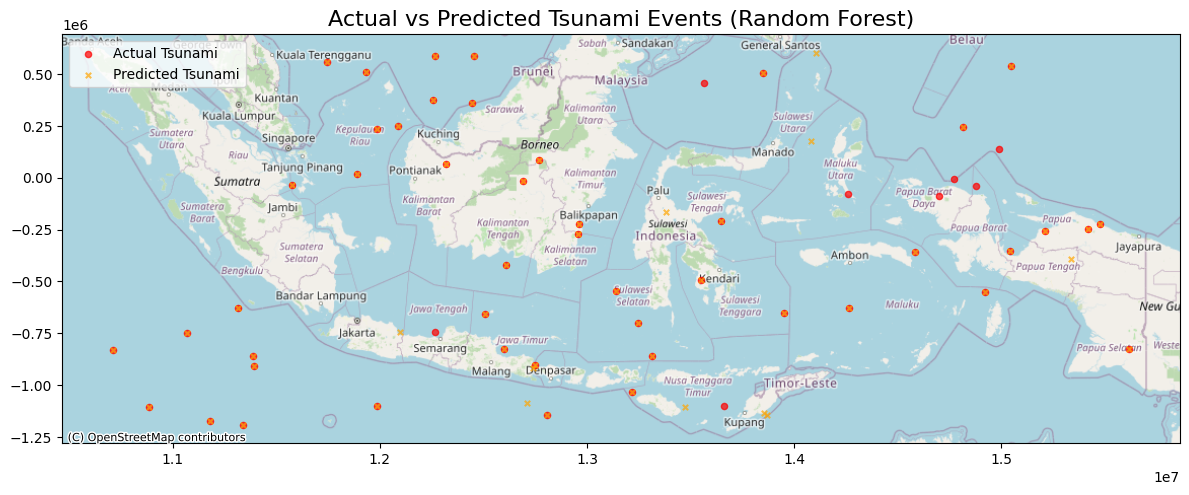

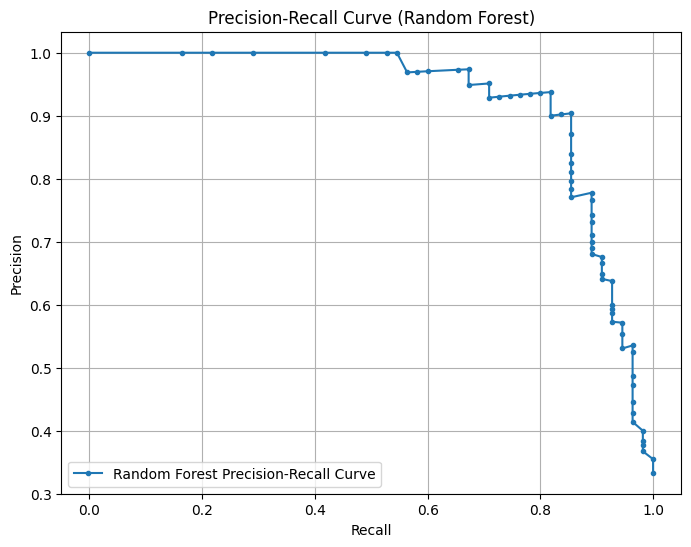


=== Visualizing Gradient Boosting (All Features) ===


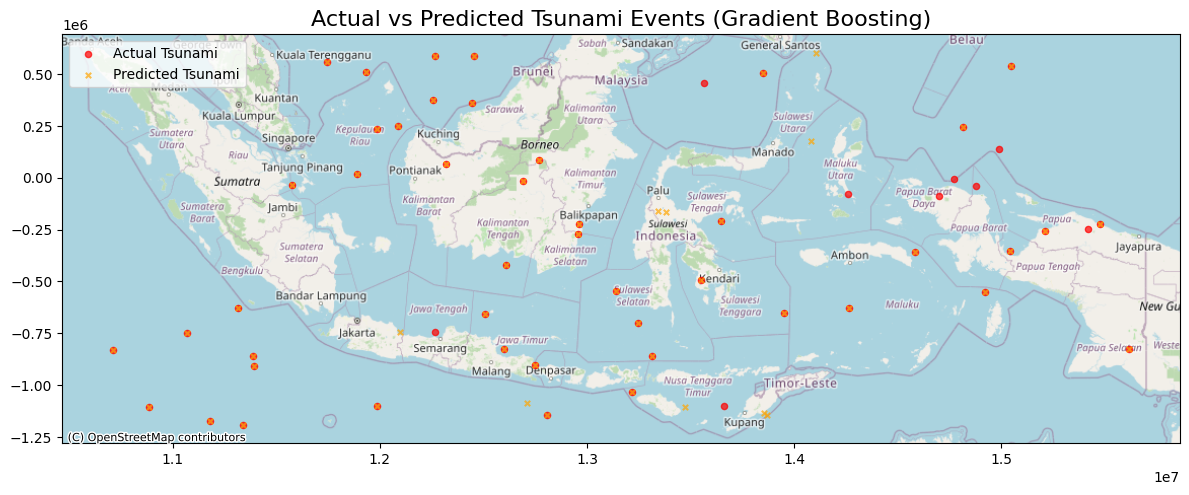

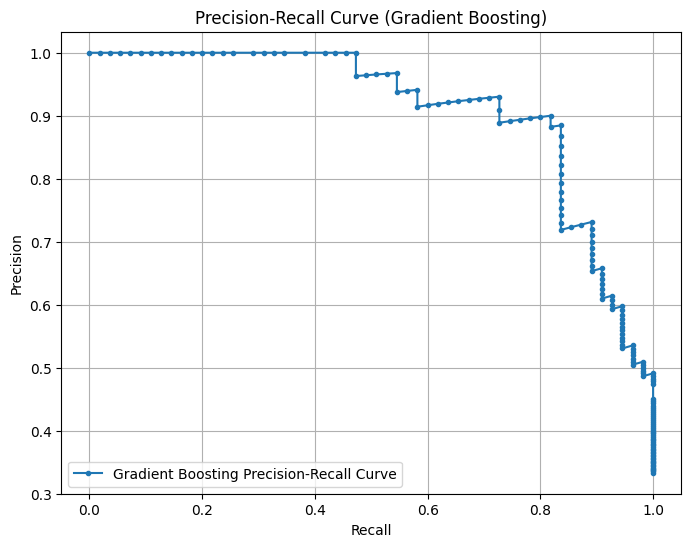

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
!pip install contextily
import contextily as ctx
from sklearn.metrics import precision_recall_curve

# Step 1: Prepare Data for Visualization (All Features)
def prepare_geodata_full(model, X_test_scaled, X_test, label):
    predicted = model.predict(X_test_scaled)
    X_test_copy = X_test.copy()  # Keep all original features
    X_test_copy[label] = predicted  # Add prediction as a new column
    return gpd.GeoDataFrame(
        X_test_copy,
        geometry=[Point(xy) for xy in zip(X_test['longitude'], X_test['latitude'])],
        crs="EPSG:4326"
    )

# Step 2: Plot Actual vs Predicted Tsunami Events
for model_name, model in models.items():
    print(f"\n=== Visualizing {model_name} (All Features) ===")

    # Prepare actual and predicted data (include all features)
    geo_actual = gpd.GeoDataFrame(
        X_test_balanced.assign(Tsunami=y_test_balanced),  # Assign actual labels
        geometry=[Point(xy) for xy in zip(X_test_balanced['longitude'], X_test_balanced['latitude'])],
        crs="EPSG:4326"
    )
    geo_predicted = prepare_geodata_full(model, X_test_balanced_scaled, X_test_balanced, f'{model_name}_Predicted')

    # Convert both GeoDataFrames to Web Mercator for basemap
    geo_actual = geo_actual.to_crs(epsg=3857)
    geo_predicted = geo_predicted.to_crs(epsg=3857)

    # Create simplified plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Plot only Actual Tsunami and Predicted Tsunami
    geo_actual[geo_actual['Tsunami'] == 1].plot(ax=ax, color='red', markersize=20, alpha=0.7, label='Actual Tsunami')
    geo_predicted[geo_predicted[f'{model_name}_Predicted'] == 1].plot(ax=ax, color='orange', markersize=15, alpha=0.7, label='Predicted Tsunami', marker='x')

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=5)

    # Set title and legend
    ax.set_title(f"Actual vs Predicted Tsunami Events ({model_name})", fontsize=16)
    ax.legend()

    plt.tight_layout()
    plt.show()

    # Step 3: Precision-Recall Curve
    try:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_balanced_scaled)[:, 1]
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test_balanced_scaled)
        else:
            y_proba = model.predict(X_test_balanced_scaled).astype(float)

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test_balanced, y_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, marker='.', label=f'{model_name} Precision-Recall Curve')
        plt.title(f"Precision-Recall Curve ({model_name})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Could not compute probability-based metrics for {model_name}: {e}")



=== Prediction Confidence Map for Logistic Regression (Filtered Ocean Points) ===


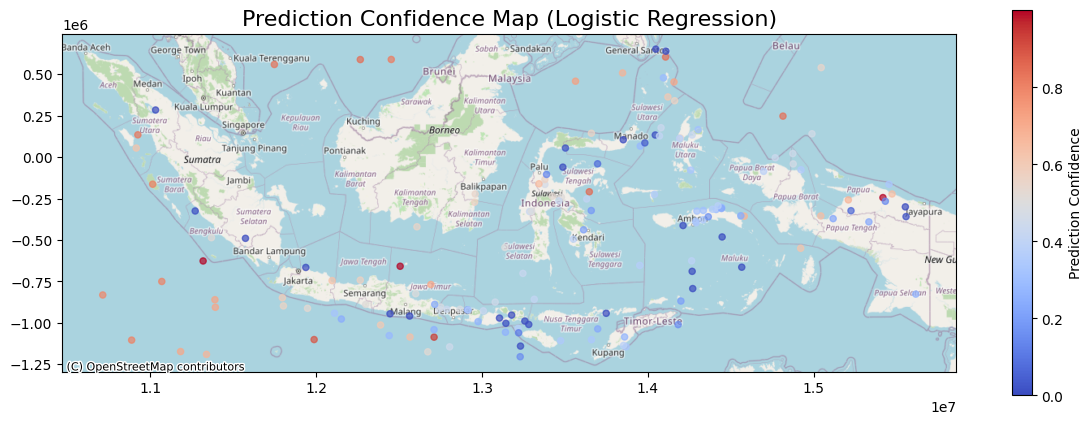


=== Prediction Confidence Map for Decision Tree (Filtered Ocean Points) ===


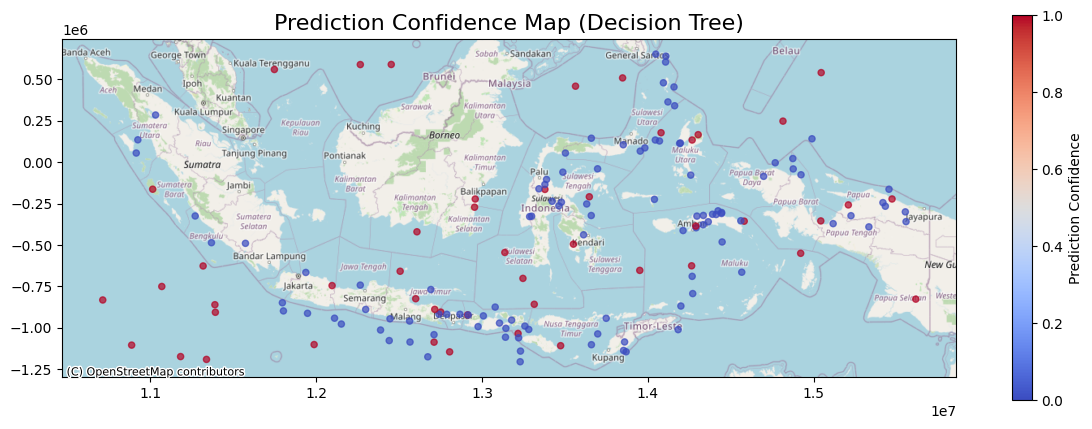


=== Prediction Confidence Map for Random Forest (Filtered Ocean Points) ===


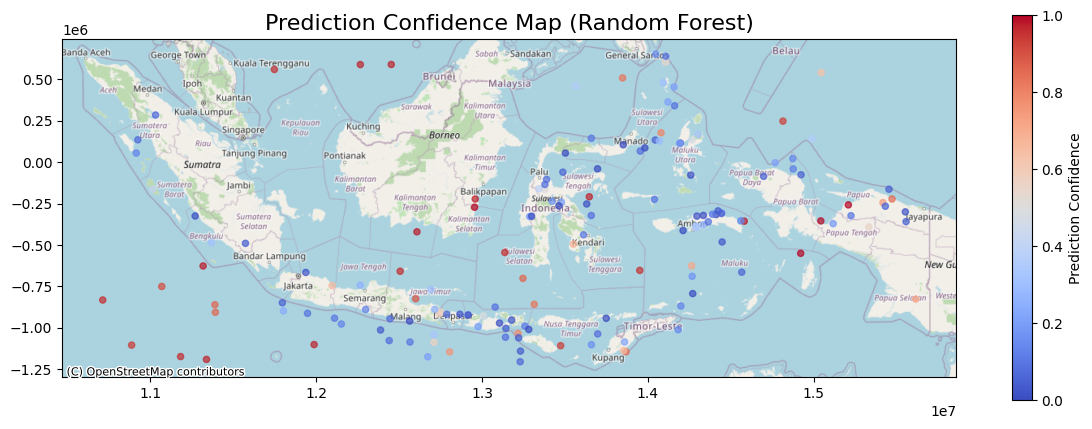


=== Prediction Confidence Map for Gradient Boosting (Filtered Ocean Points) ===


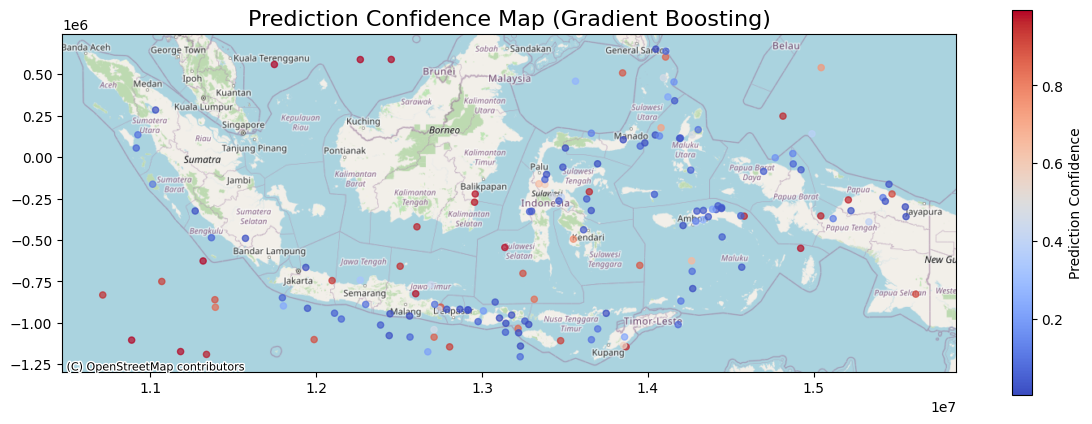

In [ ]:
# Define approximate ranges for "sea regions" (bounding box filtering)
def is_in_sea(lon, lat):
# Simple logic example: Coarse sea filter based on longitude & latitude
# Java Sea, Banda Sea, etc.
    return not (
        (95 <= lon <= 141) and (-11 <= lat <= 6) and  # Bounding box Indonesia
        (lat > -1 and lat < 5 and lon > 102 and lon < 120)  # mainland (Sumatera-Jawa-Borneo)
    )

# Filter Points Outside Land
for model_name, model in models.items():
    print(f"\n=== Prediction Confidence Map for {model_name} (Filtered Ocean Points) ===")

    # Get prediction probabilities
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_balanced_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_balanced_scaled)
    else:
        y_proba = model.predict(X_test_balanced_scaled).astype(float)

    # Create GeoDataFrame
    geo_confidence = gpd.GeoDataFrame(
        X_test_balanced.assign(Confidence=y_proba),
        geometry=[Point(xy) for xy in zip(X_test_balanced['longitude'], X_test_balanced['latitude'])],
        crs="EPSG:4326"
    )

    # Apply manual filter to keep only points in sea
    geo_confidence_sea = geo_confidence[
        geo_confidence.apply(lambda row: is_in_sea(row.geometry.x, row.geometry.y), axis=1)
    ].to_crs(epsg=3857)

    # Plot the filtered points
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    geo_confidence_sea.plot(
        ax=ax, column='Confidence', cmap='coolwarm', legend=True,
        markersize=20, alpha=0.7, legend_kwds={'label': "Prediction Confidence", "shrink": 0.5}
    )
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=5)

    ax.set_title(f"Prediction Confidence Map ({model_name})", fontsize=16)
    plt.tight_layout()
    plt.show()



=== ROC Curve for Logistic Regression ===


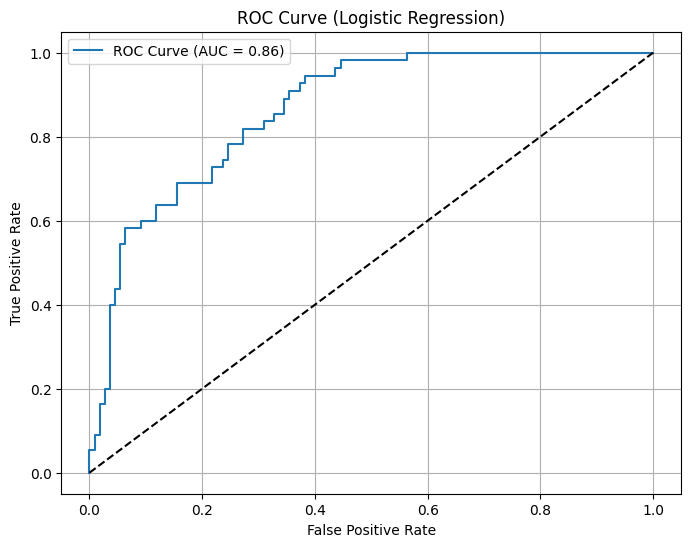


=== ROC Curve for Decision Tree ===


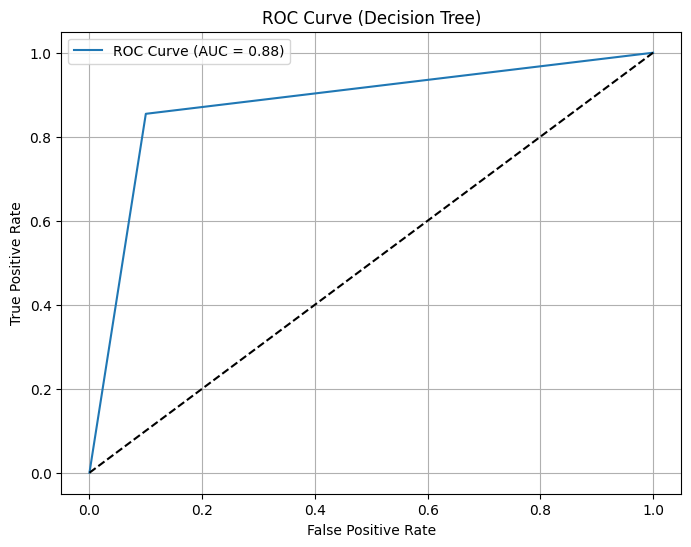


=== ROC Curve for Random Forest ===


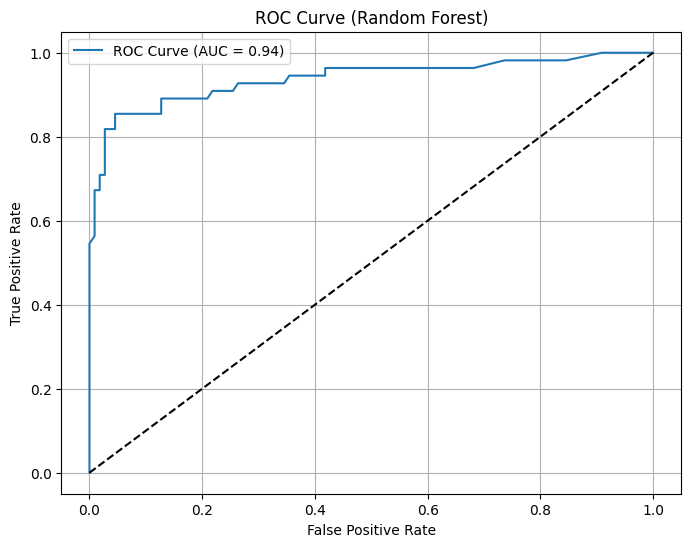


=== ROC Curve for Gradient Boosting ===


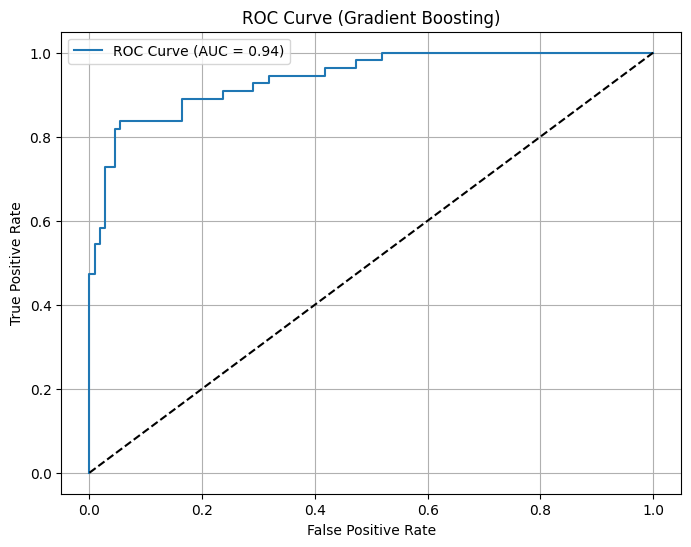

In [ ]:
from sklearn.metrics import roc_curve, auc

# Step: ROC Curve Visualization
for model_name, model in models.items():
    print(f"\n=== ROC Curve for {model_name} ===")

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_balanced_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_balanced_scaled)
    else:
        y_proba = model.predict(X_test_balanced_scaled).astype(float)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test_balanced, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title(f'ROC Curve ({model_name})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()



=== Visualizing Logistic Regression (Filtered Land Events) ===


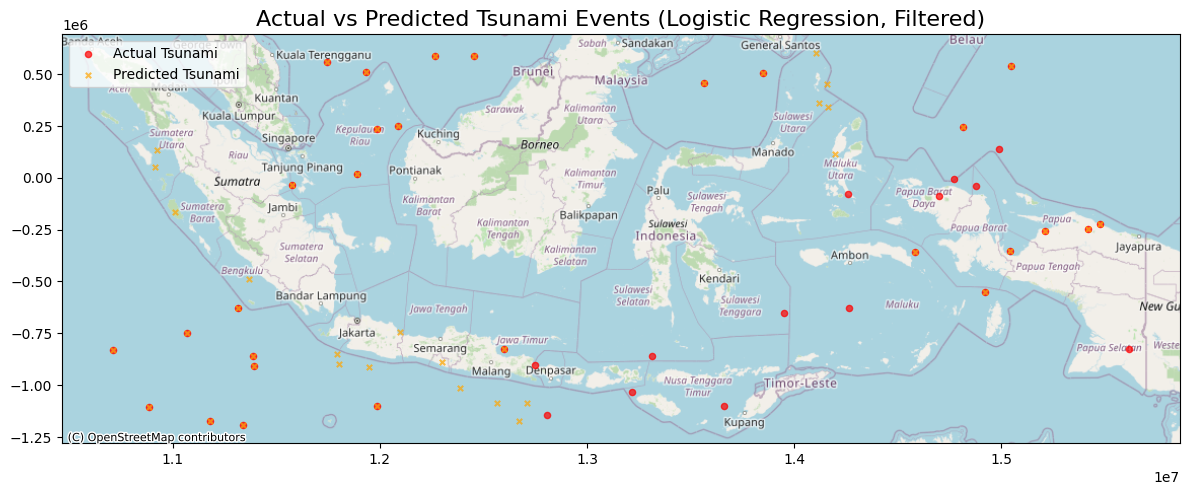


=== Visualizing Decision Tree (Filtered Land Events) ===


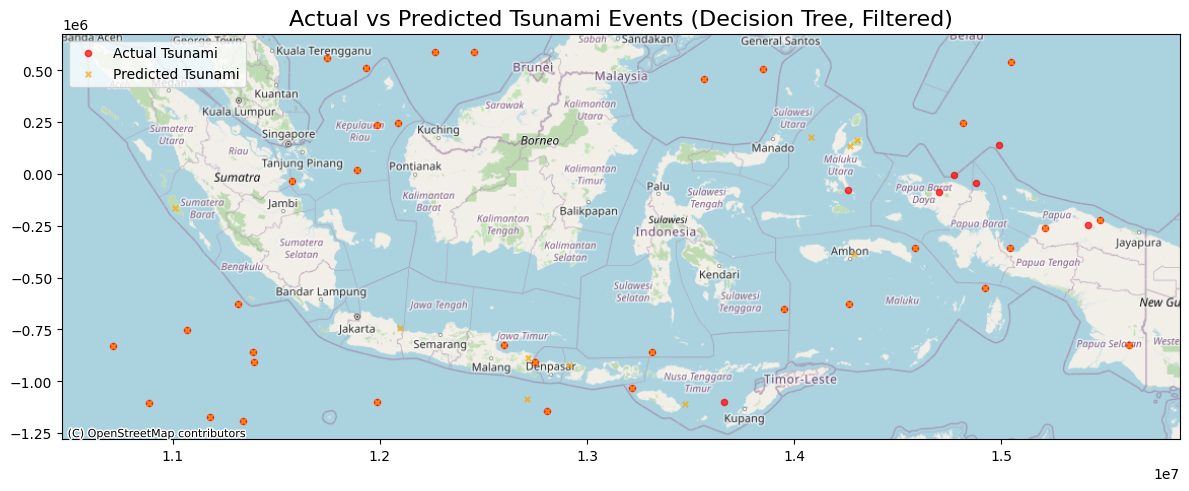


=== Visualizing Random Forest (Filtered Land Events) ===


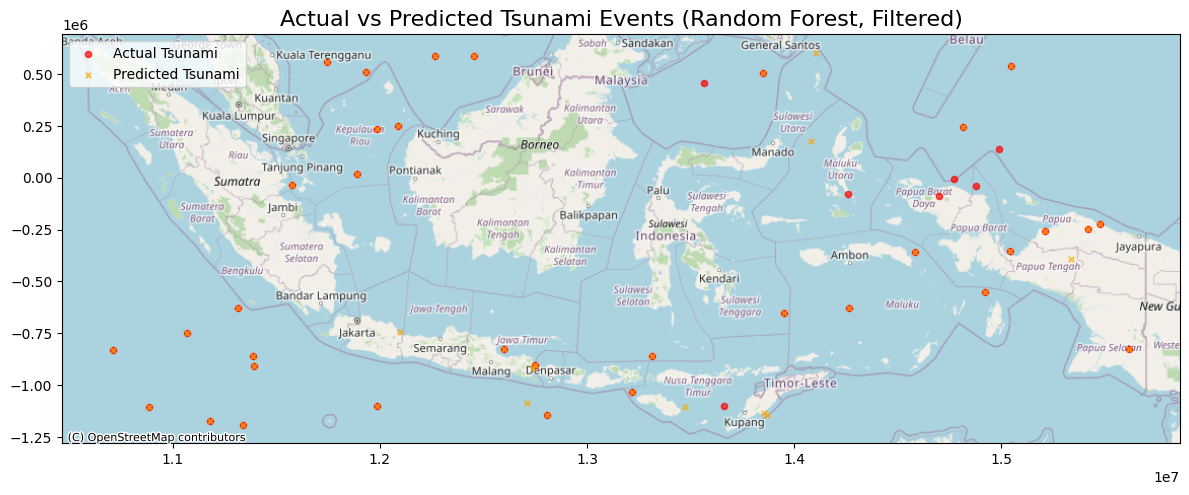


=== Visualizing Gradient Boosting (Filtered Land Events) ===


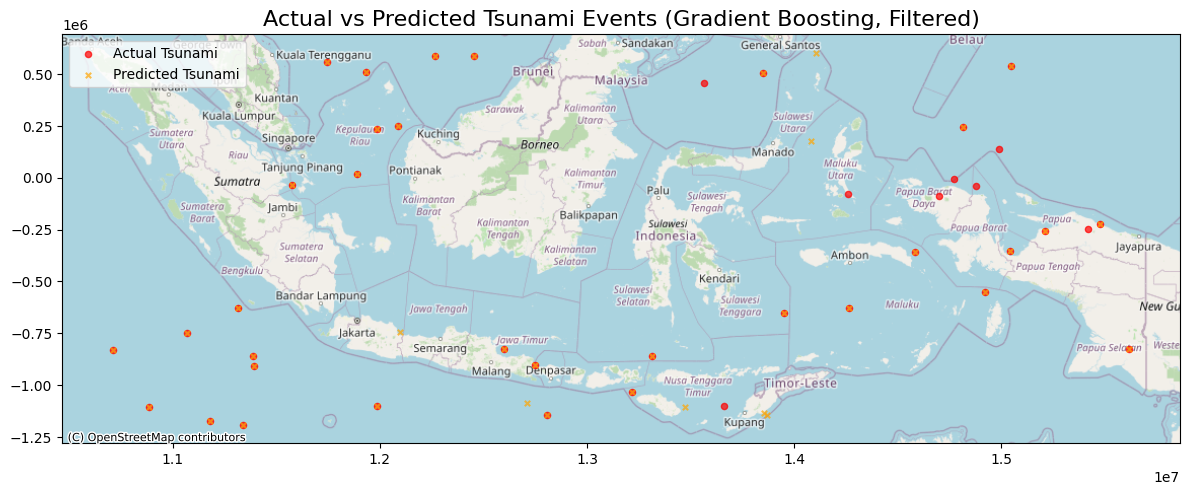

In [ ]:
# Step 1: Filter Out Tsunami Events on Land with Geographical Conditions
def filter_land_events(geo_data):
    # Contoh logika: Hapus tsunami yang berada di daratan berdasarkan wilayah geografis
    land_conditions = (
        ((geo_data['longitude'] > 109) & (geo_data['longitude'] < 120) & (geo_data['latitude'] > -7) & (geo_data['latitude'] < 4)) |  # Kalimantan
        ((geo_data['longitude'] > 120) & (geo_data['longitude'] < 125) & (geo_data['latitude'] > -5) & (geo_data['latitude'] < 2))   # Sulawesi
    )
    return geo_data[~land_conditions]  # Retain points not matching land conditions

# Step 2: Plot Actual vs Predicted Tsunami Events
for model_name, model in models.items():
    print(f"\n=== Visualizing {model_name} (Filtered Land Events) ===")

    # Prepare actual and predicted data
    geo_actual = gpd.GeoDataFrame(
        X_test_balanced.assign(Tsunami=y_test_balanced),
        geometry=[Point(xy) for xy in zip(X_test_balanced['longitude'], X_test_balanced['latitude'])],
        crs="EPSG:4326"
    )
    geo_actual = filter_land_events(geo_actual)  # Apply land filter

    geo_predicted = prepare_geodata_full(model, X_test_balanced_scaled, X_test_balanced, f'{model_name}_Predicted')
    geo_predicted = filter_land_events(geo_predicted)  # Apply land filter

    # Convert both GeoDataFrames to Web Mercator for basemap
    geo_actual = geo_actual.to_crs(epsg=3857)
    geo_predicted = geo_predicted.to_crs(epsg=3857)

    # Create filtered plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Plot only Actual Tsunami and Predicted Tsunami (filtered)
    geo_actual[geo_actual['Tsunami'] == 1].plot(ax=ax, color='red', markersize=20, alpha=0.7, label='Actual Tsunami')
    geo_predicted[geo_predicted[f'{model_name}_Predicted'] == 1].plot(ax=ax, color='orange', markersize=15, alpha=0.7, label='Predicted Tsunami', marker='x')

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=5)

    # Set title and legend
    ax.set_title(f"Actual vs Predicted Tsunami Events ({model_name}, Filtered)", fontsize=16)
    ax.legend()

    plt.tight_layout()
    plt.show()



=== Analyzing Logistic Regression ===


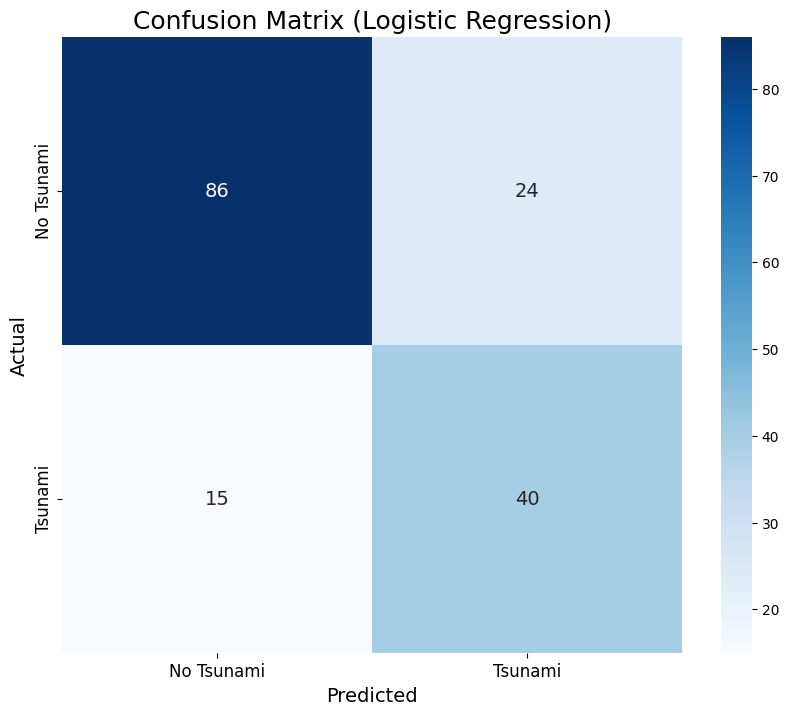

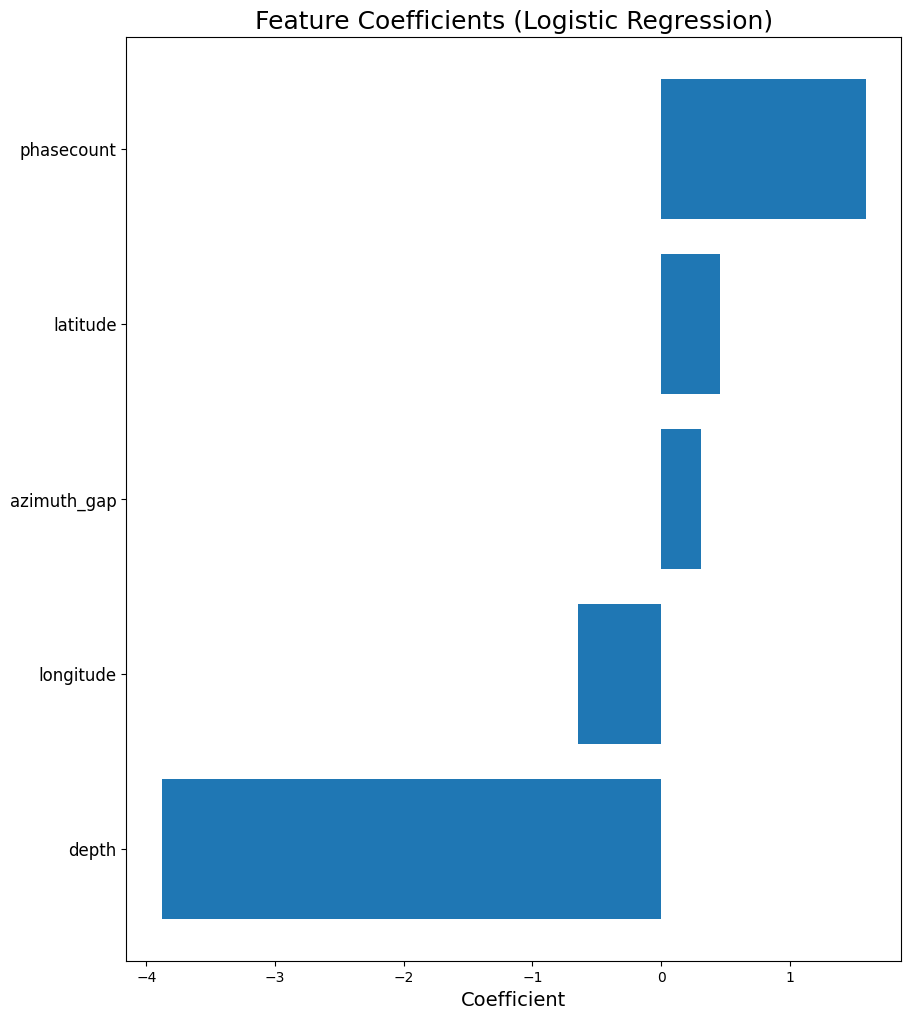


=== Analyzing Decision Tree ===


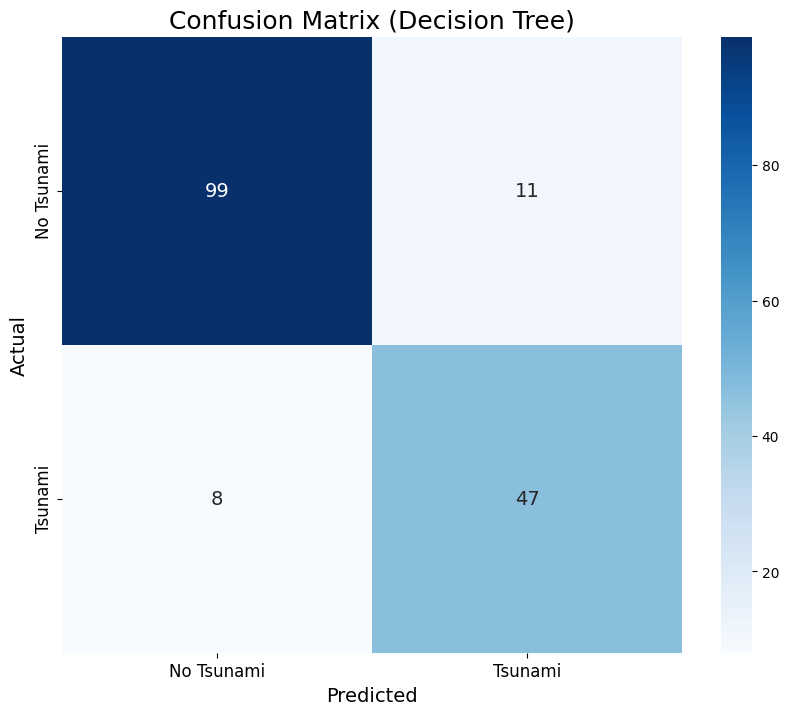

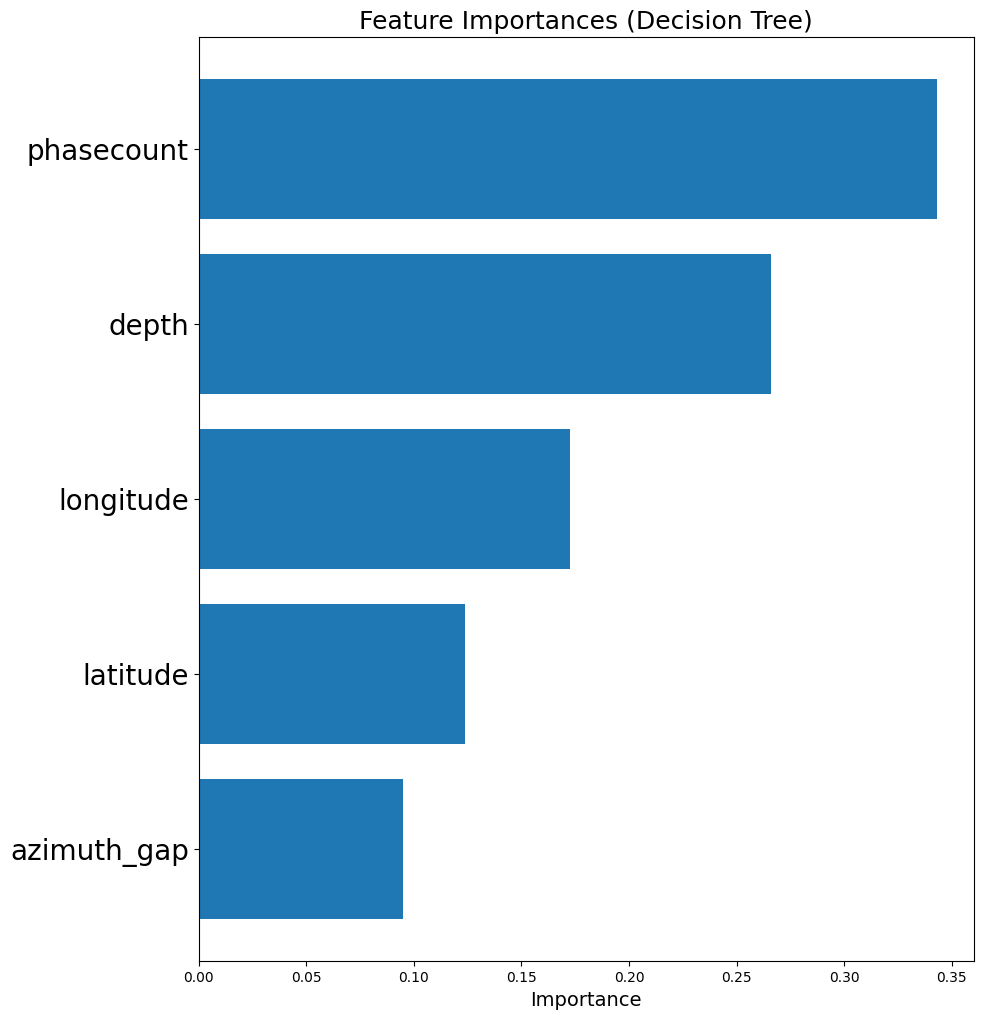


=== Analyzing Random Forest ===


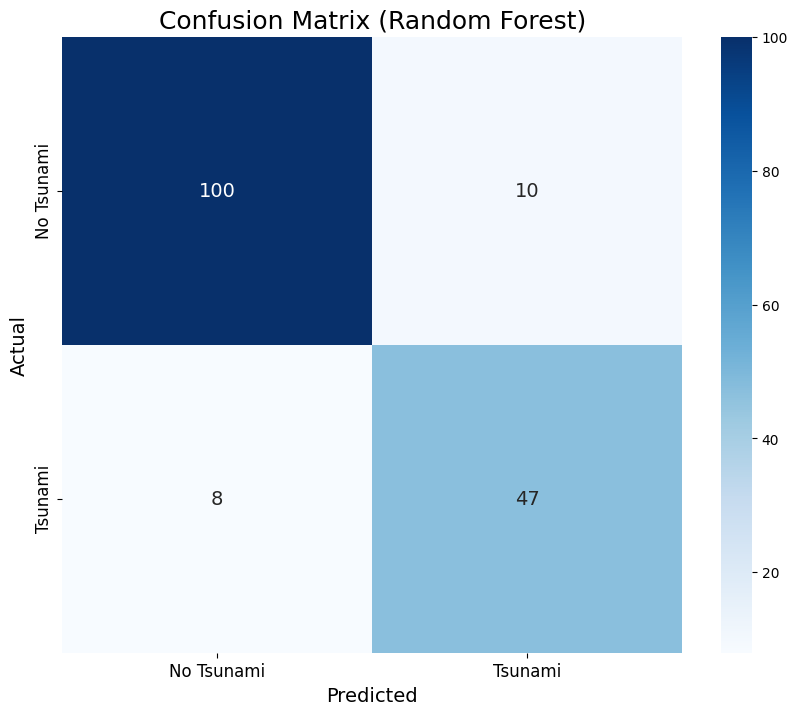

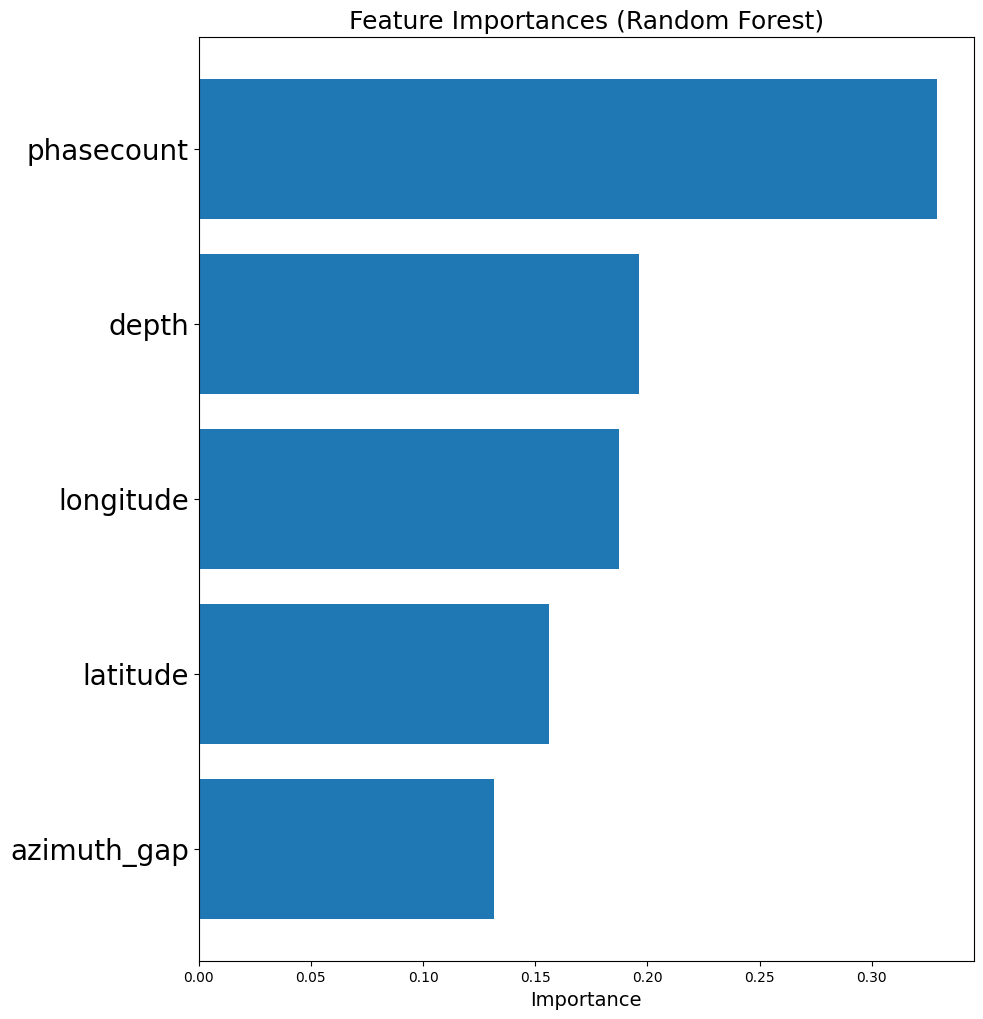


=== Analyzing Gradient Boosting ===


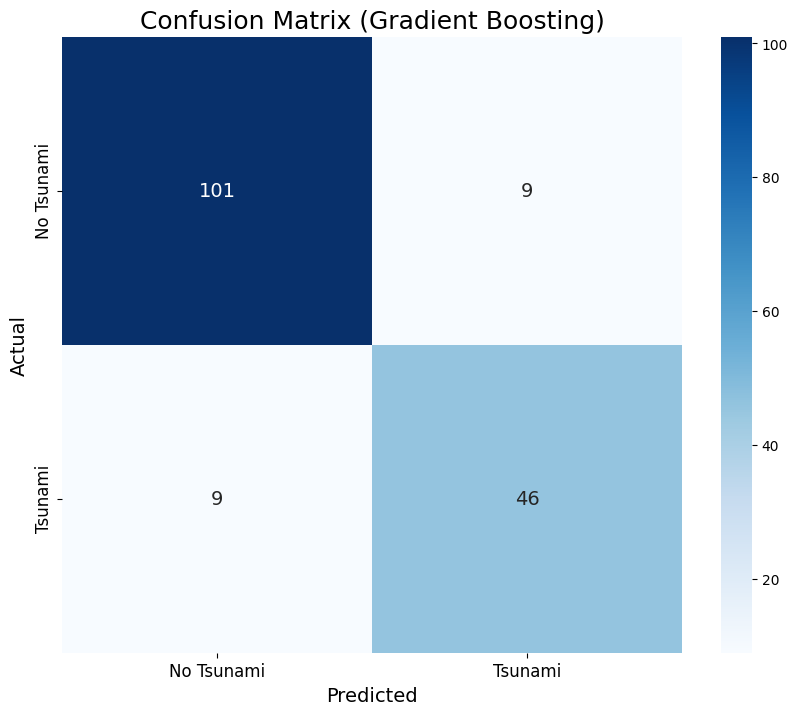

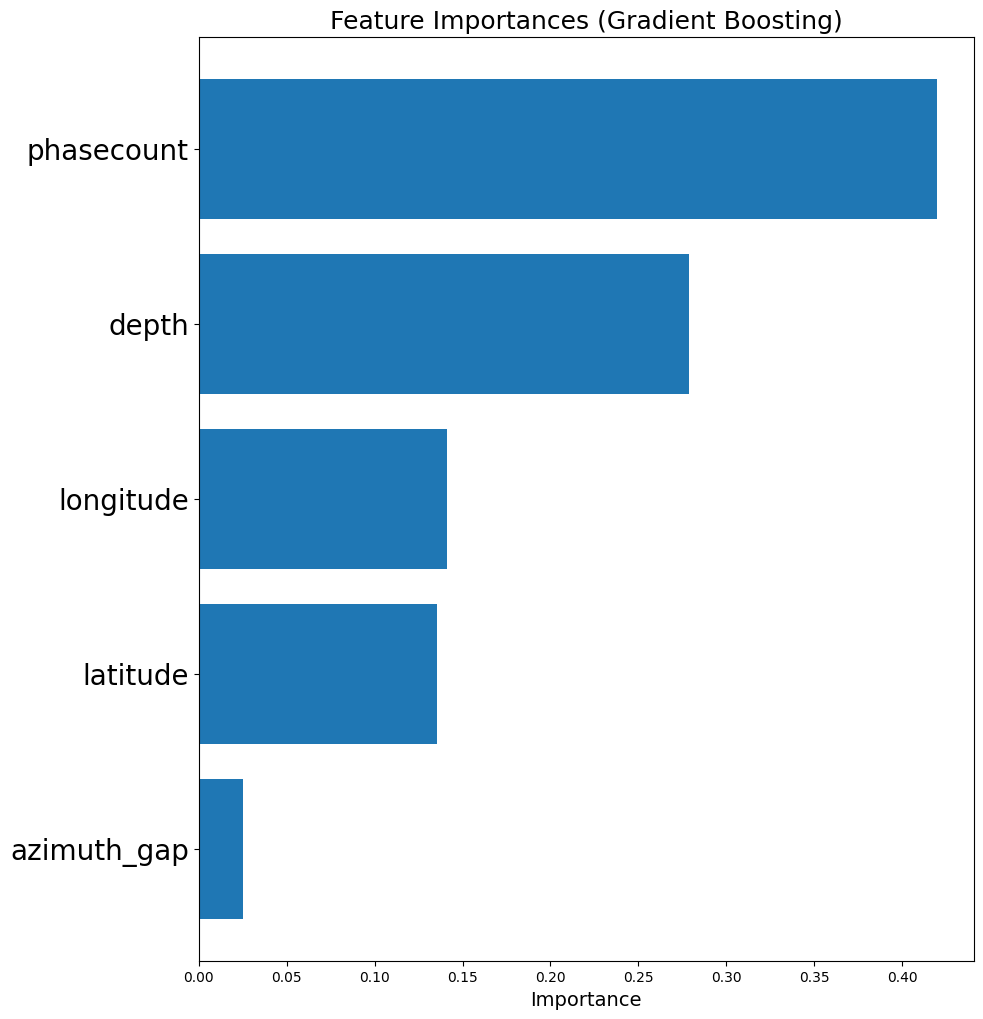

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Step 1: Confusion Matrix Visualization
def plot_confusion_matrix(model, X_test_scaled, y_test, model_name):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=['No Tsunami', 'Tsunami'],
        yticklabels=['No Tsunami', 'Tsunami'],
        annot_kws={"size": 14}
    )
    plt.title(f"Confusion Matrix ({model_name})", fontsize=18)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

# Step 2: Feature Importance Visualization
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 12))
        plt.barh(range(len(importances)), importances[indices], align="center")
        plt.yticks(range(len(importances)), [feature_names[i] for i in indices], fontsize=20)
        plt.gca().invert_yaxis()
        plt.title(f"Feature Importances ({model_name})", fontsize=18)
        plt.xlabel("Importance", fontsize=14)
        plt.show()
    elif hasattr(model, 'coef_'):
        coefficients = model.coef_[0]
        indices = np.argsort(coefficients)[::-1]

        plt.figure(figsize=(10, 12))
        plt.barh(range(len(coefficients)), coefficients[indices], align="center")
        plt.yticks(range(len(coefficients)), [feature_names[i] for i in indices], fontsize=12)
        plt.gca().invert_yaxis()
        plt.title(f"Feature Coefficients ({model_name})", fontsize=18)
        plt.xlabel("Coefficient", fontsize=14)
        plt.show()
    else:
        print(f"Model {model_name} does not support feature importance or coefficients.")

# Step 3: Iterate Through Models for Confusion Matrix and Feature Importance
for model_name, model in models.items():
    print(f"\n=== Analyzing {model_name} ===")
    try:
        plot_confusion_matrix(model, X_test_balanced_scaled, y_test_balanced, model_name)
        plot_feature_importance(model, X_test_balanced.columns, model_name)
    except Exception as e:
        print(f"Error with {model_name}: {e}")


In [ ]:
# Import yang diperlukan
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    balanced_accuracy_score, f1_score, make_scorer
)
import numpy as np
import pandas as pd

# Menentukan fitur dan target, tanpa 'magnitude' dan 'depth'
features = ['magnitude','depth','azimuth_gap', 'phasecount', 'latitude', 'longitude']
X = df[features]
y = df['tsunami']

# Step 1: Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nDistribusi data sebelum balancing (training):")
print(y_train.value_counts())

# Step 2: Downsampling
rus = RandomUnderSampler(sampling_strategy={0: 219, 1: 219}, random_state=42)
X_train_down, y_train_down = rus.fit_resample(X_train, y_train)
print("\nDistribusi data setelah downsampling (training):")
print(pd.Series(y_train_down).value_counts())

# Step 3: SMOTE untuk meningkatkan kelas minoritas
smote = SMOTE(sampling_strategy={0: 319, 1: 319}, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_down, y_train_down)
print("\nDistribusi data setelah SMOTE (training):")
print(pd.Series(y_train_smote).value_counts())

print(f"Jumlah data test: {len(X_test)}")

# Step 4: Menggunakan data testing asli tanpa modifikasi
X_test_balanced = X_test
y_test_balanced = y_test

# Pastikan distribusi data testing asli
print("\nDistribusi data testing asli (real):")
print(y_test_balanced.value_counts())

# Step 5: Scaling Data
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_balanced_scaled = scaler.transform(X_test_balanced)

# Step 6: Model Dictionary dengan lebih banyak regularisasi
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=5000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Step 7: Cross-Validation Function
def cross_validate_model(model, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    results = cross_val_score(model, X, y, scoring='roc_auc', cv=skf)
    print(f"\nCross-Validation ROC-AUC (mean): {results.mean():.4f} (std: {results.std():.4f})")

# Step 8: Evaluasi Model (tanpa visualisasi)
def evaluate_model(model, X_test, y_test):
    model.fit(X_train_smote_scaled, y_train_smote)  # Melatih model dengan data training
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    # Adjust threshold to focus on tsunami prediction
    threshold = 0.3
    y_pred_adjusted = (y_proba >= threshold).astype(int)

    print("\nConfusion Matrix (Threshold Adjusted):")
    print(confusion_matrix(y_test, y_pred_adjusted))
    print("\nClassification Report (Threshold Adjusted):")
    print(classification_report(y_test, y_pred_adjusted, target_names=["No Tsunami", "Tsunami"]))

    # Additional Metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    balanced_acc = balanced_accuracy_score(y_test, y_pred_adjusted)
    f1_minor = f1_score(y_test, y_pred_adjusted, pos_label=1)

    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"F1-Score (Tsunami): {f1_minor:.4f}")

# Step 9: Feature Importance (dihapus visualisasinya)
def get_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        print("\nFeature Importances:")
        print(feature_importance)
    elif hasattr(model, 'coef_'):
        coefficients = model.coef_[0]
        coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
        coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
        print("\nFeature Coefficients:")
        print(coef_df)

# Step 10: Evaluasi dan Visualisasi untuk Semua Model (dengan Cross-Validation)
for model_name, model in models.items():
    print(f"\n=== Evaluasi {model_name} ===")
    try:
        cross_validate_model(model, X_train_smote_scaled, y_train_smote)
        evaluate_model(model, X_test_balanced_scaled, y_test_balanced)
    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        continue

    # Tampilkan Feature Importance jika tersedia
    get_feature_importance(model, features)

# Step 11: Menampilkan Ringkasan Aktual vs Prediksi
def summarize_predictions(model, model_name, X_test, y_test):
    # Melatih model dengan data training
    model.fit(X_train_smote_scaled, y_train_smote)

    # Prediksi hasil
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    # Adjust threshold to focus on tsunami prediction
    threshold = 0.3
    y_pred_adjusted = (y_proba >= threshold).astype(int)

    tsunami_actual = y_test.sum()  # Jumlah kasus tsunami aktual
    tsunami_predicted = y_pred_adjusted.sum()  # Jumlah kasus tsunami terprediksi

    print(f"\n=== Ringkasan Prediksi {model_name} (Fokus Tsunami) ===")
    print(f"Tsunami Actual: {tsunami_actual}")
    print(f"Tsunami Predicted: {tsunami_predicted}")

# Evaluasi semua model dan tampilkan ringkasan
for model_name, model in models.items():
    print(f"\n=== Evaluasi Ringkasan {model_name} ===")
    try:
        summarize_predictions(model, model_name, X_test_balanced_scaled, y_test_balanced)
    except Exception as e:
        print(f"Error summarizing predictions for {model_name}: {e}")
        continue



Distribusi data sebelum balancing (training):
tsunami
0    93380
1      219
Name: count, dtype: int64

Distribusi data setelah downsampling (training):
tsunami
0    219
1    219
Name: count, dtype: int64

Distribusi data setelah SMOTE (training):
tsunami
0    319
1    319
Name: count, dtype: int64
Jumlah data test: 23400

Distribusi data testing asli (real):
tsunami
0    23345
1       55
Name: count, dtype: int64

=== Evaluasi Logistic Regression ===

Cross-Validation ROC-AUC (mean): 1.0000 (std: 0.0000)

Confusion Matrix (Threshold Adjusted):
[[22723   622]
 [    0    55]]

Classification Report (Threshold Adjusted):
              precision    recall  f1-score   support

  No Tsunami       1.00      0.97      0.99     23345
     Tsunami       0.08      1.00      0.15        55

    accuracy                           0.97     23400
   macro avg       0.54      0.99      0.57     23400
weighted avg       1.00      0.97      0.98     23400

ROC-AUC Score: 0.9997
Balanced Accuracy: 0.986